In [1]:
# Install required packages
!pip install matplotlib networkx numpy obonet pandas scikit-learn

  Using cached obonet-1.1.1-py3-none-any.whl.metadata (6.7 kB)
Using cached obonet-1.1.1-py3-none-any.whl (9.2 kB)


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import obonet
import math
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
from sklearn.model_selection import KFold

ModuleNotFoundError: No module named 'obonet'

Calculating semantic similarity of diseases

In [64]:
url = 'https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/main/src/ontology/doid.obo'
HDO_Net = obonet.read_obo(url)

In [65]:
def get_SV(disease, w):
    S = HDO_Net.subgraph(nx.descendants(HDO_Net, disease) | {disease})
    SV = dict()
    shortest_paths = nx.shortest_path(S, source=disease)
    for x in shortest_paths:
        SV[x] = math.pow(w, (len(shortest_paths[x]) - 1))
    return SV

In [66]:
def get_similarity(d1, d2, w):
    SV1 = get_SV(d1, w)
    SV2 = get_SV(d2, w)
    intersection_value= 0
    for disease in (set(SV1.keys()) & set(SV2.keys())):
        intersection_value = intersection_value + SV1[disease]
        intersection_value = intersection_value + SV2[disease]
    return intersection_value / (sum(SV1.values()) + sum(SV2.values()))

In [67]:
def getDiSiNet(dilen, diseases, w):
    diSiNet = np.zeros((dilen, dilen))
    for d1 in range(dilen):
        if diseases[d1] in HDO_Net.nodes:
            for d2 in range(d1 + 1, dilen):
                if diseases[d2] in HDO_Net.nodes:
                    diSiNet[d1, d2] = diSiNet[d2, d1] = get_similarity(diseases[d1], diseases[d2], w)
    return diSiNet

Compute Functional Similarity

In [68]:
def PBPA(RNA_i, RNA_j, di_sim, rna_di):
    diseaseSet_i = rna_di[RNA_i] > 0
    diseaseSet_j = rna_di[RNA_j] > 0
    diseaseSim_ij = di_sim[diseaseSet_i][:, diseaseSet_j]
    ijshape = diseaseSim_ij.shape
    if ijshape[0] == 0 or ijshape[1] == 0:
        return 0
    return (sum(np.max(diseaseSim_ij, axis=0)) + sum(np.max(diseaseSim_ij, axis=1))) / (ijshape[0] + ijshape[1])

In [69]:
def getRNASiNet(RNAlen, diSiNet, rna_di):
    RNASiNet = np.zeros((RNAlen, RNAlen))
    for i in range(RNAlen):
        for j in range(i + 1, RNAlen):
            RNASiNet[i, j] = RNASiNet[j, i] = PBPA(i, j, diSiNet, rna_di)
    return RNASiNet

Compute Gaussian kernel similarity

In [70]:
def getTuneParam(matrix):
    rows = matrix.shape[0]
    cols = matrix.shape[1]
    EUC_LD = np.linalg.norm(matrix, ord=2, axis=1, keepdims=False)
    EUC_DL = np.linalg.norm(matrix.T, ord=2, axis=1, keepdims=False)
    EUC_LD = EUC_LD ** 2
    EUC_DL = EUC_DL ** 2
    sum_EUC_LD = np.sum(EUC_LD)
    sum_EUC_DL = np.sum(EUC_DL)
    lncRNA_param = 1 / ((1 / rows) * sum_EUC_LD)
    disease_param = 1 / ((1 / cols) * sum_EUC_DL)
    return lncRNA_param, disease_param

In [71]:
def getGauSiNet(matrix, lncRNA_param, disease_param):
    LD = np.asmatrix(matrix)
    DL = LD.T
    lncRNA_number = LD.shape[0]
    disease_number = LD.shape[1]
    l = []
    d = []
    for i in range(lncRNA_number):
        for j in range(lncRNA_number):  
            b_1 = LD[i] - LD[j]
            b_norm1 = np.linalg.norm(b_1, ord=None, axis=1, keepdims=False)
            b1 = b_norm1 ** 2
            b1 = math.exp(-lncRNA_param * b1)
            l.append(b1)
    for i in range(disease_number):
        for j in range(disease_number):
            b_2 = DL[i] - DL[j]
            b_norm2 = np.linalg.norm(b_2, ord=None, axis=1, keepdims=False)
            b2 = b_norm2 ** 2
            b2 = math.exp(-disease_param * b2)
            d.append(b2)
    GLL = np.asmatrix(l).reshape(lncRNA_number, lncRNA_number)
    GDD = np.asmatrix(d).reshape(disease_number, disease_number)
    np.fill_diagonal(GLL, 0)
    np.fill_diagonal(GDD, 0)
    return GLL, GDD

Deep Topology Feature Extraction

In [72]:
def getMGSiNet(channel_num, FMatrix, GMatrix):
    FG = []
    matrix = FMatrix + GMatrix
    matrix = matrix / np.max(matrix)
    np.fill_diagonal(matrix, 0)
    FG.append(matrix)
    for _ in range(1, channel_num):
        FMatrix = matrix * FMatrix
        GMatrix = matrix * GMatrix
        matrix = FMatrix + GMatrix
        matrix = matrix / np.max(matrix)
        np.fill_diagonal(matrix, 0)
        FG.append(matrix)
    return FG

Splitting the dataset

In [73]:
# Getting positive and negative samples
def get_posi_nega_ij(lnclen, dilen, lnc_di):
    positive_ij = []
    negative_ij = []
    for i in range(lnclen):
        for j in range(dilen):
            label = lnc_di[i, j]
            if label == 1:
                positive_ij.append((i, j + lnclen))
            elif label == 0:
                negative_ij.append((i, j + lnclen))
    positive_ij = np.array(positive_ij)
    negative_ij = np.array(negative_ij)
    return positive_ij, negative_ij

In [74]:
# Split the dataset by 5-CVs
def folds(posi_len, nega_len):
    positive_idx = np.array(range(0, posi_len))
    negative_idx = np.array(range(0, nega_len))
    # Disrupting the index of positive and negative samples
    random.shuffle(positive_idx)
    random.shuffle(negative_idx)
    positive5foldsidx = []
    negative5foldsidx = []
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(positive_idx):
        positive_train_idx = positive_idx[train_index]
        positive_test_idx = positive_idx[test_index]
        positive5foldsidx.append({'train': positive_train_idx, 'test': positive_test_idx})
    # Randomly select the same number of negative samples as positive samples
    for train_index, test_index in kf.split(negative_idx[:posi_len]):
        negative_train_idx = negative_idx[train_index]
        negative_test_idx = negative_idx[test_index]
        negative5foldsidx.append({'train': negative_train_idx, 
                                  'test': negative_test_idx})
        negative5foldsidx.append({'train': negative_train_idx, 'test': negative_test_idx})
    positive5foldsidx = np.array(positive5foldsidx)
    negative5foldsidx = np.array(negative5foldsidx)
    return (positive5foldsidx, negative5foldsidx)

matrix splicing

In [75]:
def cancatenate(lnclen, dilen, milen, lnc_di, lnc_mi, mi_di, lncSiNet, diSiNet, miSiNet):
    A = np.zeros((lnclen + dilen + milen, lnclen + dilen + milen))
    A[: lnclen, lnclen: lnclen + dilen] = lnc_di
    A[lnclen: lnclen + dilen, : lnclen] = lnc_di.T
    A[: lnclen, lnclen + dilen: ] = lnc_mi
    A[lnclen + dilen: , : lnclen] = lnc_mi.T
    A[lnclen: lnclen + dilen, lnclen + dilen: ] = mi_di.T
    A[lnclen + dilen: , lnclen: lnclen + dilen] = mi_di
    A[: lnclen, : lnclen] = lncSiNet
    A[lnclen: lnclen + dilen, lnclen: lnclen + dilen] = diSiNet
    A[lnclen + dilen: , lnclen + dilen: ] = miSiNet
    return A

preset parameter

In [76]:
dataset = "dataset3"
network_num = 4

Splitting the dataset

In [77]:
disease = pd.read_csv('./our_dataset/' + dataset +'/basic/disease.csv', header=None).values
lncRNAs = pd.read_csv('./our_dataset/' + dataset +'/basic/lncRNA.csv', header=None).values
miRNAs = pd.read_csv('./our_dataset/' + dataset +'/basic/miRNA.csv', header=None).values
lnc_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_di.csv')
lnc_di.set_index('0', inplace=True)
lnc_di = lnc_di.values
diseaseLen = len(disease)
lncRNALen = len(lncRNAs)
miRNALen = len(miRNAs)

In [78]:
positive_ij, negative_ij = get_posi_nega_ij(lncRNALen, diseaseLen, lnc_di)
positiveLen = len(positive_ij)
negativeLen = len(negative_ij)
positive5foldsidx, negative5foldsidx = folds(positiveLen, negativeLen)

In [79]:
# np.save('./our_dataset/' + dataset + '/index/positive_ij', positive_ij)
# np.save('./our_dataset/' + dataset + '/index/negative_ij', negative_ij)
# np.save('./our_dataset/' + dataset + '/index/positive5foldsidx', positive5foldsidx)
# np.save('./our_dataset/' + dataset + '/index/negative5foldsidx', negative5foldsidx)

Computing semantic similarity of diseases

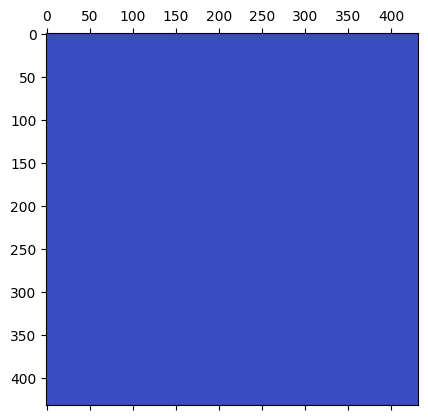

In [80]:
diseases = pd.read_csv("./our_dataset/" + dataset + "/basic/disease.csv", header=None)[0]
diseaseSemanticNet = getDiSiNet(diseases.shape[0], diseases, 0.5)
diseaseSemanticNet.astype(int)
plt.matshow(diseaseSemanticNet, cmap=plt.cm.coolwarm, vmin = 0, vmax = 1)

# diseaseSemanticNet = pd.read_csv('./our_dataset/' + dataset + '/interaction/di_di_semantics.csv', index_col='dis').values 
# plt.matshow(diseaseSemanticNet, cmap=plt.cm.coolwarm, vmin = 0, vmax = 1)

Computing functional similarity of miRNAs

In [81]:
miRNA = pd.read_csv('./our_dataset/' + dataset + '/basic/miRNA.csv', header=None)[0]
mi_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/mi_di.csv')
mi_di.set_index('0', inplace=True)
mi_di = mi_di.values

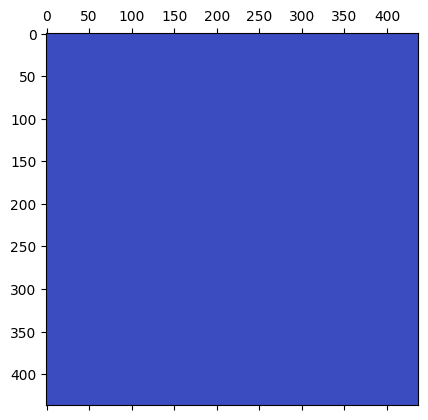

In [82]:
miFunSiNet = getRNASiNet(RNAlen=len(miRNA), diSiNet=copy.copy(diseaseSemanticNet), rna_di=copy.copy(mi_di))
plt.matshow(miFunSiNet, cmap=plt.cm.coolwarm, vmin=0, vmax=1)

Computing Gaussian kernel similarity of miRNAs

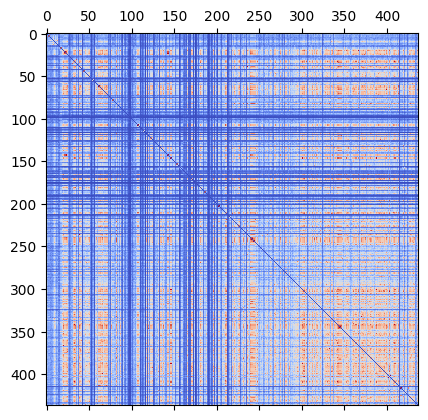

In [83]:
miRNA_param, disease_param = getTuneParam(mi_di)
miGauSiNet, _ = getGauSiNet(mi_di, miRNA_param, disease_param)
plt.matshow(miGauSiNet, cmap=plt.cm.coolwarm, vmin=0, vmax=1)

Functional similarity and Gaussian kernel similarity of integrated miRNAs based on deep topological feature extraction

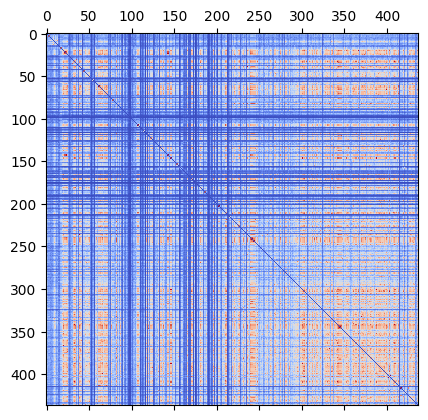

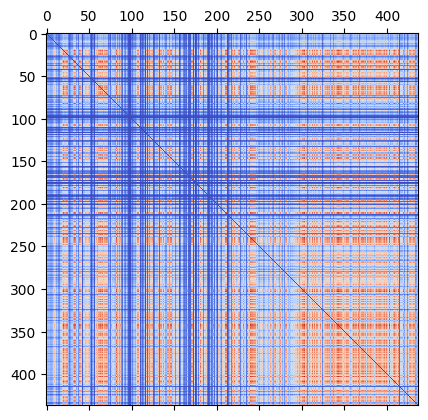

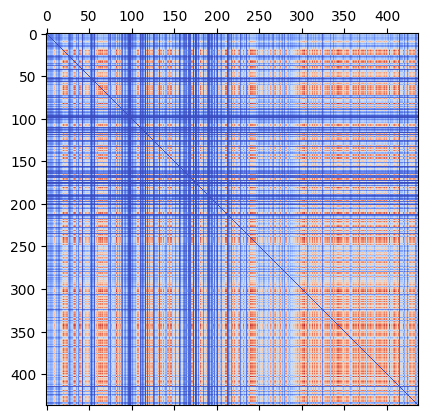

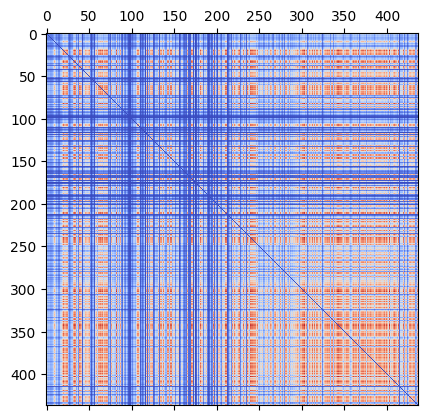

In [84]:
MergeFGMiSiNet = getMGSiNet(network_num, miFunSiNet, miGauSiNet)
for i in range(network_num):
    plt.matshow(MergeFGMiSiNet[i], cmap=plt.cm.coolwarm, vmin=0, vmax=1)

Construction of multi-view heterogeneous networks based on deep topology feature extraction according to 5-CV splitting

In [85]:
lnc_mi = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_mi.csv', index_col='0').values

In [86]:
for fold in range(positive5foldsidx.shape[0]):
    print(f"第{fold}折")
    lnc_di_copy = copy.copy(lnc_di)
    # Reset relationships in the test set to 0
    for ij in positive_ij[positive5foldsidx[fold]['test']]:
        lnc_di_copy[ij[0], ij[1] - lncRNALen] = 0
    # Computing functional similarity of lncRNAs
    lncFunSiNet = getRNASiNet(lncRNALen, copy.copy(diseaseSemanticNet), lnc_di_copy)
    # Computing Gaussian kernel similarity of lncRNAs
    lncRNA_param, disease_param = getTuneParam(lnc_di_copy)
    lncGauSiNet, diGauSiNet = getGauSiNet(lnc_di_copy, lncRNA_param=lncRNA_param, disease_param=disease_param)
    # Functional similarity and Gaussian kernel similarity of integrated lncRNAs based on deep topological feature extraction
    MergeFGLncSiNet = getMGSiNet(network_num, lncFunSiNet, lncGauSiNet)
    # Semantic similarity and Gaussian kernel similarity of integrated diseases based on deep topological feature extraction
    MergeFGDiSiNet = getMGSiNet(network_num, diseaseSemanticNet, diGauSiNet)

    for i in range(network_num):
        A = cancatenate(lncRNALen, diseaseLen, miRNALen, lnc_di_copy, lnc_mi, mi_di, MergeFGLncSiNet[i], MergeFGDiSiNet[i], MergeFGMiSiNet[i])
        # plt.matshow(A, cmap=plt.cm.coolwarm, vmin=0, vmax=1)
        # np.save('./our_dataset/' + dataset + '/A/A_' + str(fold + 1) + '_' + str(i + 1), A)

第0折
第1折
第2折
第3折
第4折
